In [1]:
import src.DetectingRegionInfo as DetectingRegionInfo
import src.DopplerInfo as DopplerInfo

import src.LinesGenerator as LinesGenerator
import src.WAndDopplerGenerator as WAndDopplerGenerator
import src.FeaturesAndLabelsGenerator as FeaturesAndLabelsGenerator

import src.Config as Config
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

# create info structs from config
detecting_region_info = DetectingRegionInfo.DetectingRegionInfo(
    Config.transmittor_position, Config.receiver_position_1, Config.receiver_position_2, Config.receiver_position_3)
doppler_info = DopplerInfo.DopplerInfo(Config.c, Config.fc, Config.v)

In [2]:
def visualize_lines(detecting_region_info, lines):
    _, ax = plt.subplots()
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 150)
    ax.add_patch(Polygon([detecting_region_info.v1,
                 detecting_region_info.v2, detecting_region_info.v4, detecting_region_info.v3], fill=False))

    # Plot the lines
    for i in range(len(lines)):
        line = lines[i]
        ax.plot([point[0] for point in line], [point[1]
                for point in line], "r")

    plt.show()


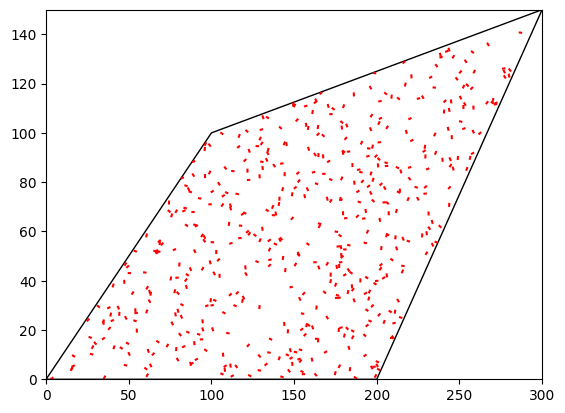

In [3]:
# training features and labels

[lines_a, lines_b] = LinesGenerator.generateLines(
    detecting_region_info=detecting_region_info,
    a_b_distance=Config.a_b_distance,
    num_of_lines_to_generate=Config.train_num_of_lines_to_generate,
    step_count_per_line=Config.train_step_count_per_line,
    length_per_step=Config.length_per_step,
    angle_change_limit_per_step=Config.angle_change_limit_per_step
)

[w, doppler] = WAndDopplerGenerator.generateWAndDoppler(
    detecting_region_info=detecting_region_info,
    doppler_info=doppler_info,
    lines_a=lines_a,
    lines_b=lines_b
)

[train_features, train_labels] = FeaturesAndLabelsGenerator.generateFeaturesAndLabels(
    detecting_region_info=detecting_region_info,
    lines_a=lines_a,
    w=w,
    doppler=doppler,
    num_of_lines_to_generate=Config.train_num_of_lines_to_generate,
    step_count_per_line=Config.train_step_count_per_line
)

visualize_lines(detecting_region_info, lines_a)

In [ ]:
# testing features and labels

[lines_a, lines_b] = LinesGenerator.generateLines(
    detecting_region_info=detecting_region_info,
    a_b_distance=Config.a_b_distance,
    num_of_lines_to_generate=1,
    step_count_per_line=Config.test_set_num + (Config.train_step_count_per_line - 1),
    length_per_step=Config.length_per_step,
    angle_change_limit_per_step=Config.angle_change_limit_per_step
)

[lines_a, lines_b] = LinesGenerator.reparseSingleLineAsLines(
    line_a=lines_a[0],
    line_b=lines_b[0],
    num_of_lines_to_generate=Config.test_set_num,
    step_count_per_line=Config.train_step_count_per_line
)

[w, doppler] = WAndDopplerGenerator.generateWAndDoppler(
    detecting_region_info=detecting_region_info,
    doppler_info=doppler_info,
    lines_a=lines_a,
    lines_b=lines_b
)

[test_features, test_labels] = FeaturesAndLabelsGenerator.generateFeaturesAndLabels(
    detecting_region_info=detecting_region_info,
    lines_a=lines_a,
    w=w,
    doppler=doppler,
    num_of_lines_to_generate=Config.test_set_num,
    step_count_per_line=Config.train_step_count_per_line
)


visualize_lines(detecting_region_info, lines_a)

In [ ]:
import os
import time

current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
result_folder = "results/" + current_time
os.makedirs(result_folder)

training_results_folder = result_folder + "/training"
os.makedirs(training_results_folder)

testing_results_folder_1= result_folder + "/testing1"
os.makedirs(testing_results_folder_1)

testing_results_folder_2= result_folder + "/testing2"
os.makedirs(testing_results_folder_2)


In [ ]:
import numpy as np

# the label is [the distance to detecting_region_info.transimssion_position from the point, the angle between x axis and the line from the point to detecting_region_info.transimssion_position], i want to convert to the coordinates of the point


def labels_to_coords(detecting_region_info, labels):
    ref = detecting_region_info.transmittor_position

    coords = []

    for label in labels:
        distance = label[0]
        angle = label[1]

        x = ref[0] + distance * np.cos(angle)
        y = ref[1] + distance * np.sin(angle)

        coords.append([x, y])

    return np.array(coords)


def plot_result(detecting_region_info, loss_to_show, trues, predicteds, folder_name, plot_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(
        trues[:, 0],
        trues[:, 1],
        label="True",
        marker="o",
        s=30,
        alpha=0.7,
    )
    plt.scatter(
        predicteds[:, 0],
        predicteds[:, 1],
        label="Predicted",
        marker="x",
        s=30,
        alpha=0.7,
    )
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.legend()
    plt.title("True vs. Predicted")
    plt.grid(True)
    
    # draw the polygon
    plt.gca().add_patch(Polygon([detecting_region_info.v1, detecting_region_info.v2, detecting_region_info.v4, detecting_region_info.v3], fill=False))

    plt.text(
        0,
        0,
        f"Loss: {loss_to_show}",
        ha="left",
        va="bottom",
        transform=plt.gca().transAxes,
    )
    test_result_name = folder_name + '/' + plot_name
    plt.savefig(test_result_name)

    plt.show()

In [ ]:
# 定义更深的神经网络模型
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output

import src.Config as cf
import src.TrajectoryDataset as TrajectoryDataset

import src.UavModel as UavModel

# 创建训练和测试数据集
train_dataset = TrajectoryDataset.TrajectoryDataset(train_features, train_labels)
test_dataset = TrajectoryDataset.TrajectoryDataset(test_features, test_labels)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=cf.train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=cf.test_batch_size, shuffle=False)

# 使用GPU加速
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

using_model = UavModel.UavModel()
model = using_model.to(device)

for param in model.parameters():
    print(type(param), param.size())

# 损失函数和优化器s
optimizer = optim.Adam(model.parameters(), lr=cf.learning_rate)
criterion = nn.MSELoss()

# 训练模型
loss_values = []  # 存储损失值以供绘图

for epoch in range(cf.epoch):
    model.train()
    total_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_avg_loss = total_loss / len(train_loader)
    loss_values.append(train_avg_loss)

    # 动态绘图
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(loss_values, label="Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.text(epoch, loss.item(), f"Loss: {loss.item()}", ha="right")

    train_result_name = training_results_folder + "/up-to-date-loss.png"
    plt.savefig(train_result_name)
    plt.show()

    # 打印损失信息
    print(f"Epoch [{epoch+1}/{cf.epoch}], Loss: {loss.item()}")

    # 测试模型
    model.eval()
    total_test_loss = 0
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            test_loss = criterion(outputs, labels)
            total_test_loss += test_loss.item()
            predicted_labels.append(outputs.cpu().numpy())
            true_labels.append(labels.cpu().numpy())

    # 合并所有批次的预测结果和真实值
    predicted_labels = np.concatenate(predicted_labels, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    
    # predicted_coords = labels_to_coords(detecting_region_info, predicted_labels)
    # true_coords = labels_to_coords(detecting_region_info, true_labels)
    
    # plot_result(
    #     trues=true_coords,
    #     predicteds=predicted_coords,
    #     folder_name=testing_results_folder_1,
    #     plot_name=f"epoch-{epoch}-test-result.png"
    # )
    
    test_avg_loss = total_test_loss / len(test_loader)
    plot_result(
        detecting_region_info=detecting_region_info,
        loss_to_show=test_avg_loss,
        trues=true_labels,
        predicteds=predicted_labels,
        folder_name=testing_results_folder_2,
        plot_name=f"epoch-{epoch}-test-result.png"
    )

    print(f"Test Loss: {total_test_loss / len(test_loader)}")
